---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Generating regular lattices and visualizing shortest paths
### Creating data for testing and demonstrating routes

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is a walk-through for:**

1. Instantiating a simple network through a generated regular lattice
2. Generating shortest path geometric objects
3. Visualizing shortest paths

In [29]:
%config InlineBackend.figure_format = "retina"

In [30]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-12-22T12:56:49.697367-06:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.18.1

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [31]:
import libpysal
from libpysal.cg import Point
import matplotlib
import matplotlib.pyplot as plt
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.4.3

spaghetti : 1.7.5.dev16+gb14c9e7
libpysal  : 4.9.2
matplotlib: 3.8.2



-----------------------------
### 1. Demonstration with a synthetic network
#### 1.1 Instantiate a network from a 4x4 regular lattice

In [32]:
lattice = spaghetti.regular_lattice((0,0,3,3), 2, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:100: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


#### 1.2. Extract network elements and visualize them

In [33]:
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

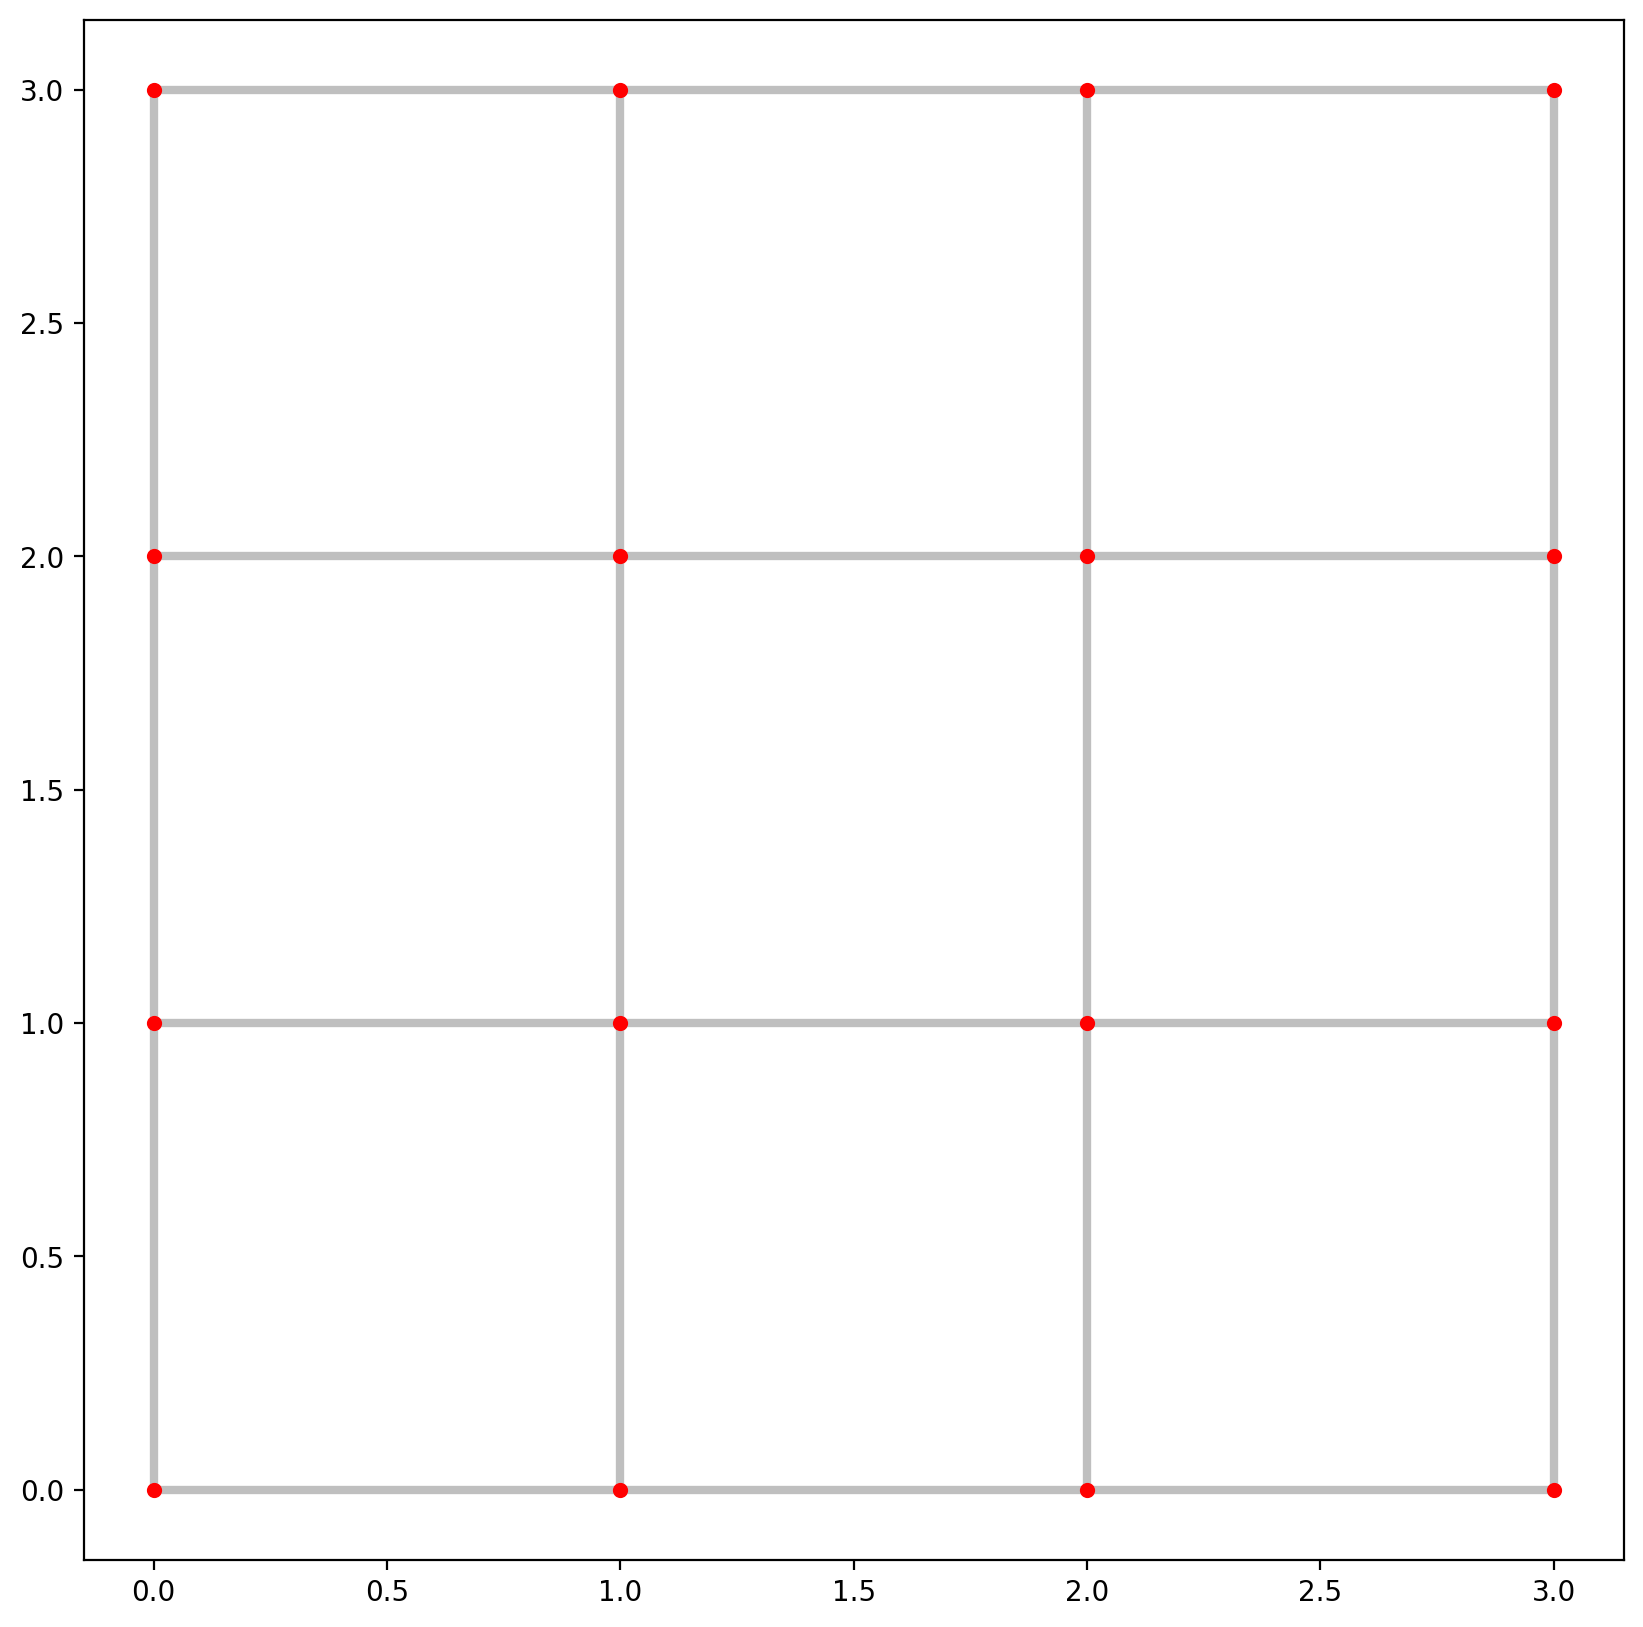

In [34]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=20, color="red", zorder=1);

#### 1.3. Instantiate several synthetic observations and snap them to the network

In [35]:
synth_obs = [Point([0.2, 1.3]), Point([0.2, 1.7]), Point([2.8, 1.5])]
ntw.snapobservations(synth_obs, "synth_obs")

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:100: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:1797: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


#### 1.4. Extract point patterns and visualize plot
##### Note the labeling for network elements and observations

In [36]:
# true locations of synthetic observations
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="synth_obs")
# snapped locations of synthetic observations
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="synth_obs", snapped=True)

#### 1.4.1. Defined helper functions for labeling

In [37]:
def arc_labels(a, b, s):
    """Label each leg of the tour."""
    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]
    kws = {"size": s, "ha": "center", "va": "bottom"}
    a.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Helper for labeling vertices."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)
    
def obs_labels(o, b, s, c="g"):
    """Label each point pattern observation."""
    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "style": "oblique", "c":c}
    o.apply(lambda x: b.annotate(text=x.id, xy=_lab_loc(x), **kws), axis=1)

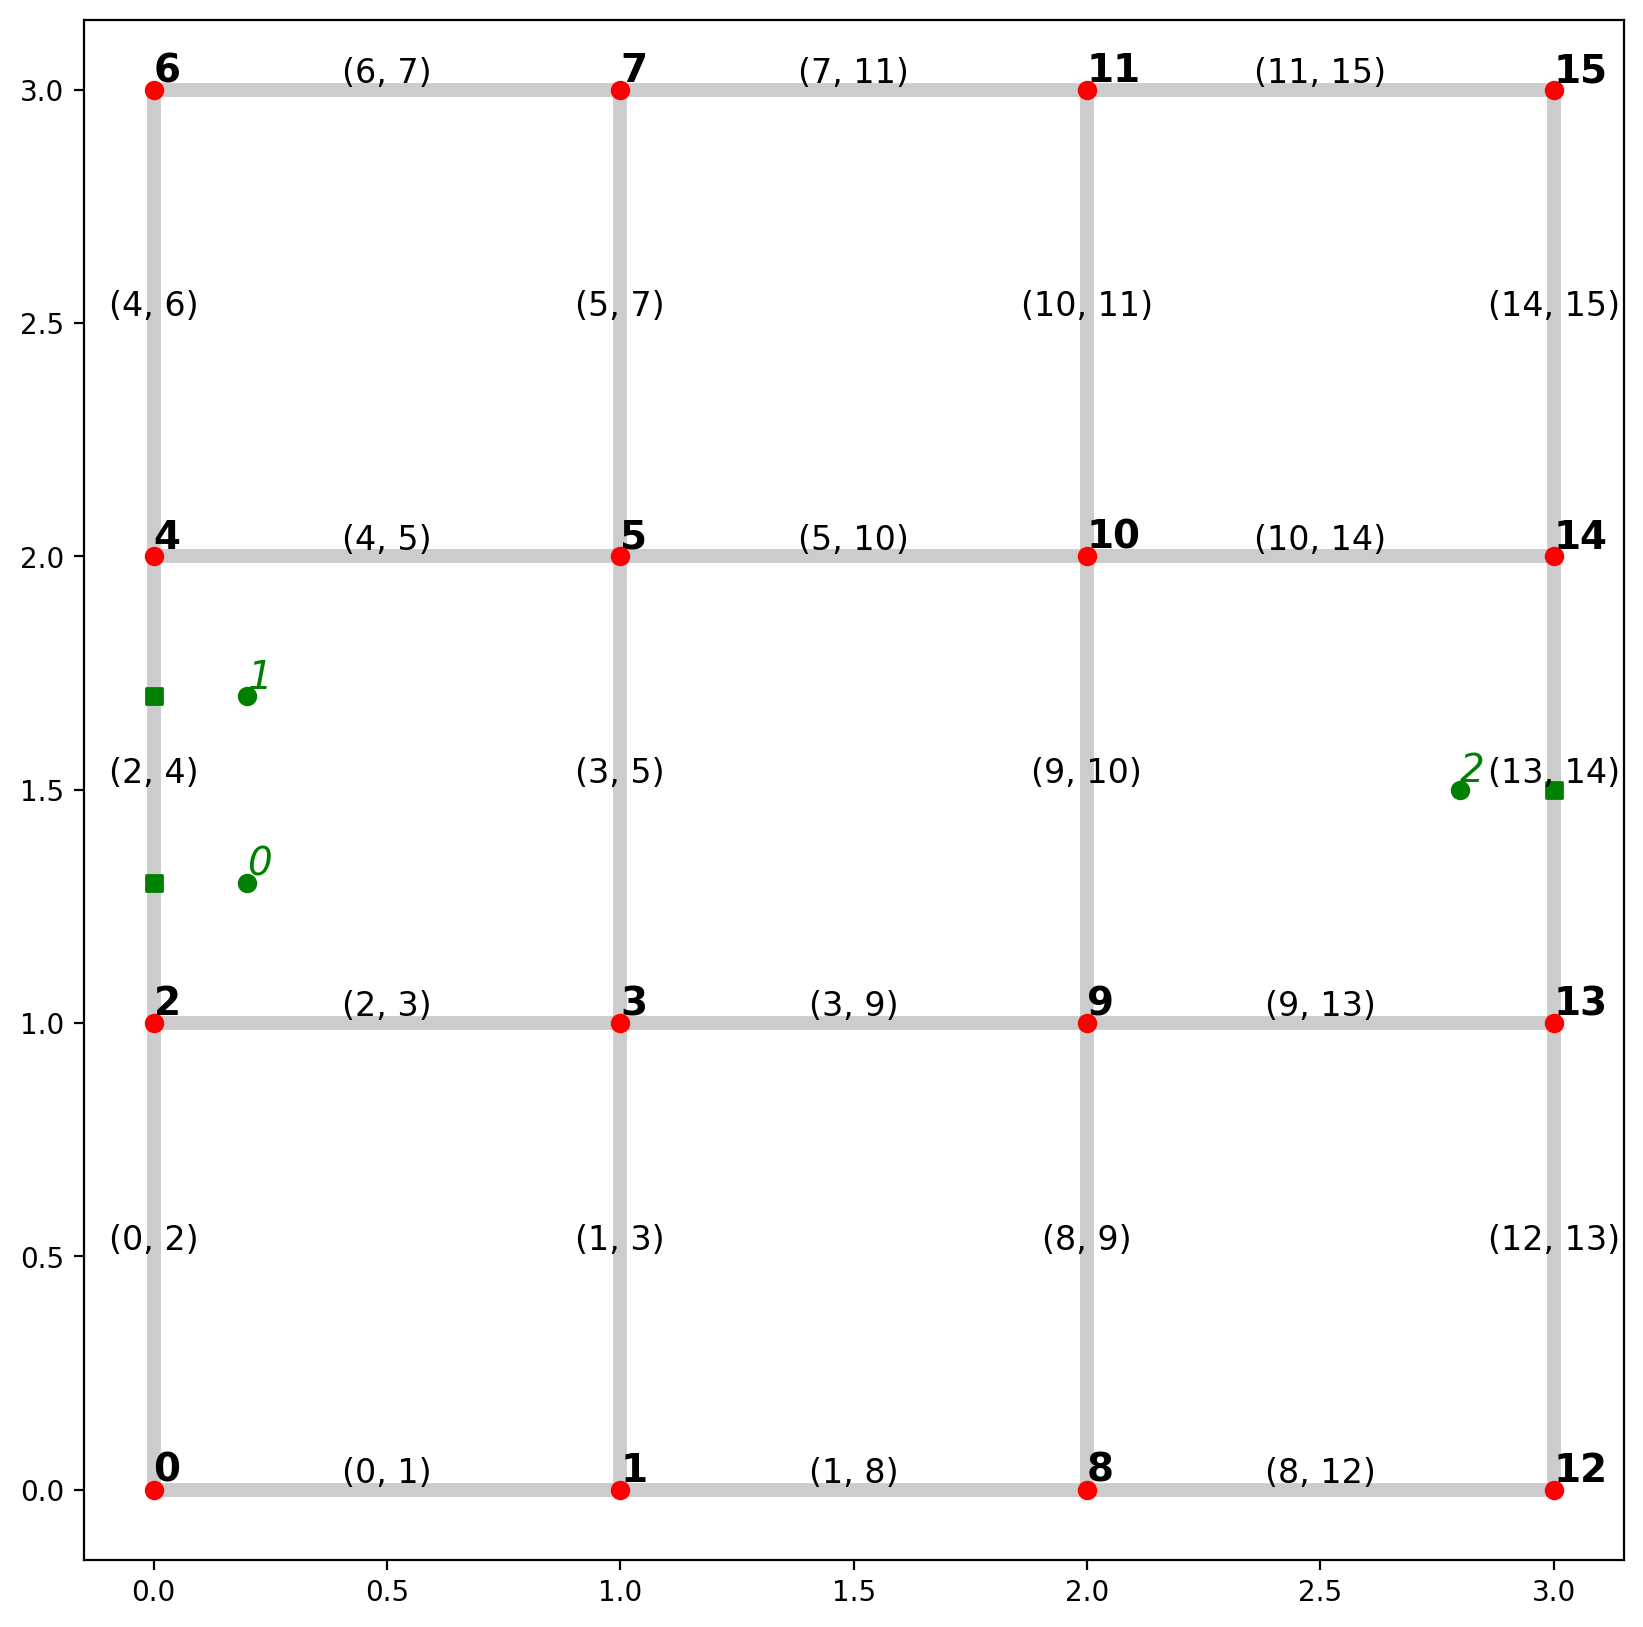

In [38]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
vertices.plot(ax=base, color="r", zorder=1)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arc_labels(arcs, base, 12)
# vertex labels
vert_labels(vertices, base, 14)
# synthetic observation labels
obs_labels(pp_obs, base, 14);

#### 1.5. Generate observation shortest path trees

In [39]:
d2d_dist, tree = ntw.allneighbordistances("synth_obs", gen_tree=True)
d2d_dist

array([[nan, 0.4, 3.8],
       [0.4, nan, 3.8],
       [3.8, 3.8, nan]])

##### Note that a tag of ``(-0.1, -0.1)`` labels the points as being snapped to the same network arc

In [40]:
tree

{(0, 1): (-0.1, -0.1), (0, 2): (2, 13), (1, 2): (4, 14)}

#### 1.6. Generate shortest paths as ``libpysal.cg.Chain`` objects

In [41]:
paths = ntw.shortest_paths(tree, "synth_obs")
paths

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:100: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


[[(0, 1), <libpysal.cg.shapes.Chain at 0x28c61c6b0>],
 [(0, 2), <libpysal.cg.shapes.Chain at 0x17de94d40>],
 [(1, 2), <libpysal.cg.shapes.Chain at 0x17dfd04a0>]]

#### 1.7. Extract the shortest paths within ``geopandas.GeoDataFrame`` and plot

In [42]:
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf

,id,geometry
0,"(0, 1)","LINESTRING (0.00000 1.30000, 0.00000 1.70000)"
1,"(0, 2)","LINESTRING (0.00000 1.30000, 0.00000 1.00000, ..."
2,"(1, 2)","LINESTRING (0.00000 1.70000, 0.00000 2.00000, ..."


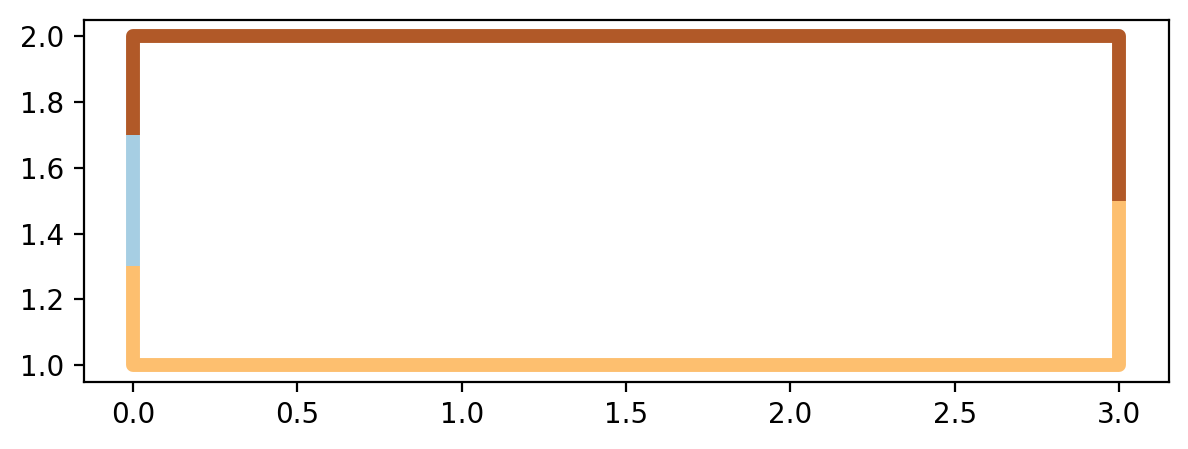

In [43]:
paths_gdf.plot(figsize=(7, 7), column=paths_gdf.index.name, cmap="Paired", linewidth=5);

#### 1.8. Plot the routes within the context of the network

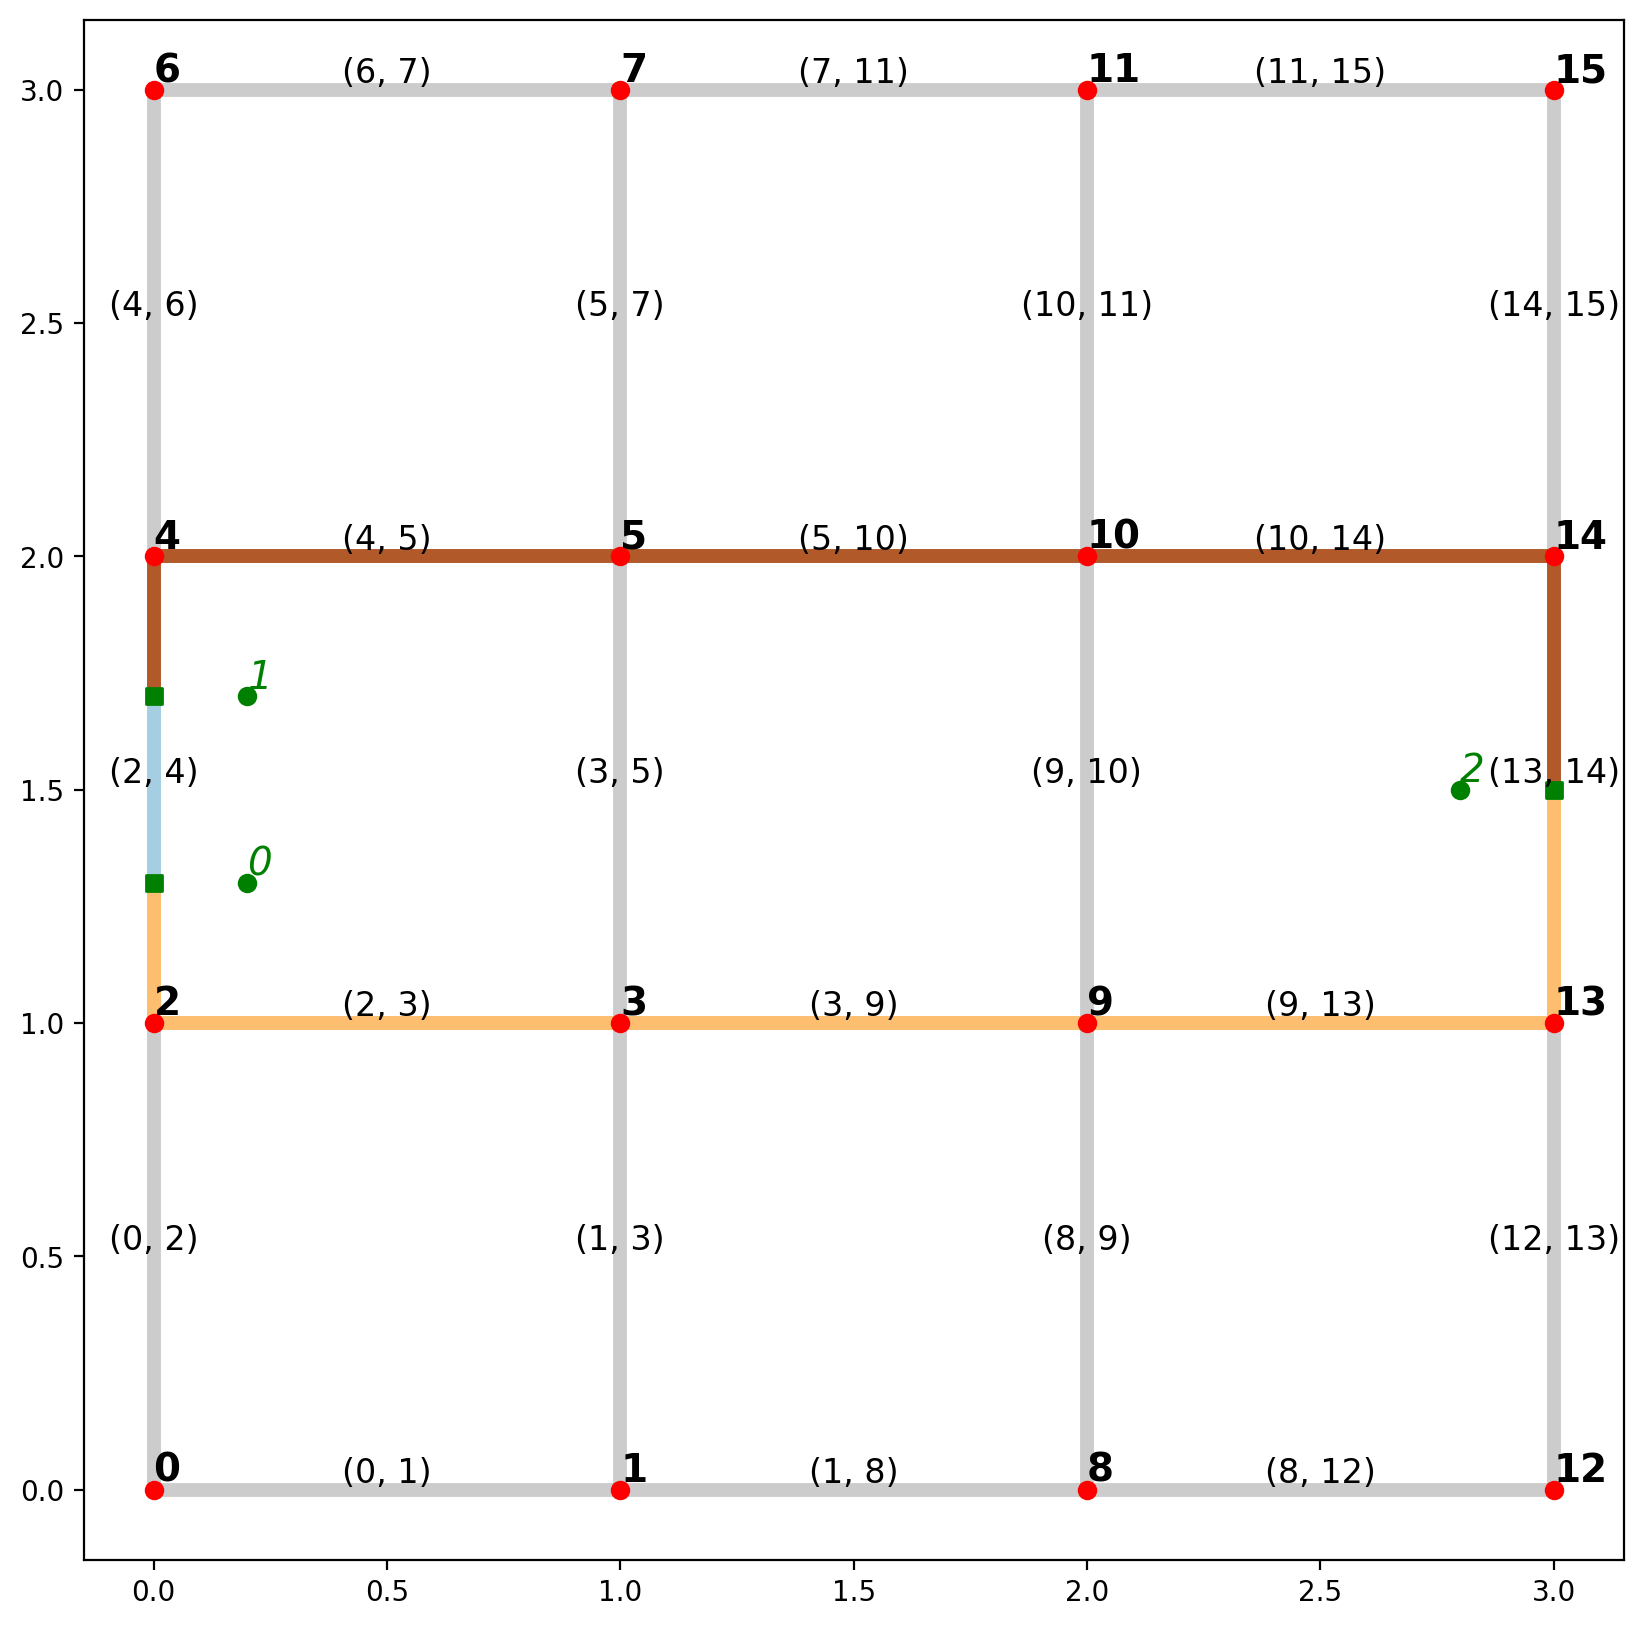

In [44]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=5, zorder=1)
vertices.plot(ax=base, color="r", zorder=2)
pp_obs.plot(ax=base, color="g", zorder=3)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
# arc labels
arc_labels(arcs, base, 12)
# vertex labels
vert_labels(vertices, base, 14)
# synthetic observation labels
obs_labels(pp_obs, base, 14);

-----------------------------------
### 2. Demostration with emprical datasets
#### 2.1 Instantiate an emprical network, extract elements, and visualize

In [45]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


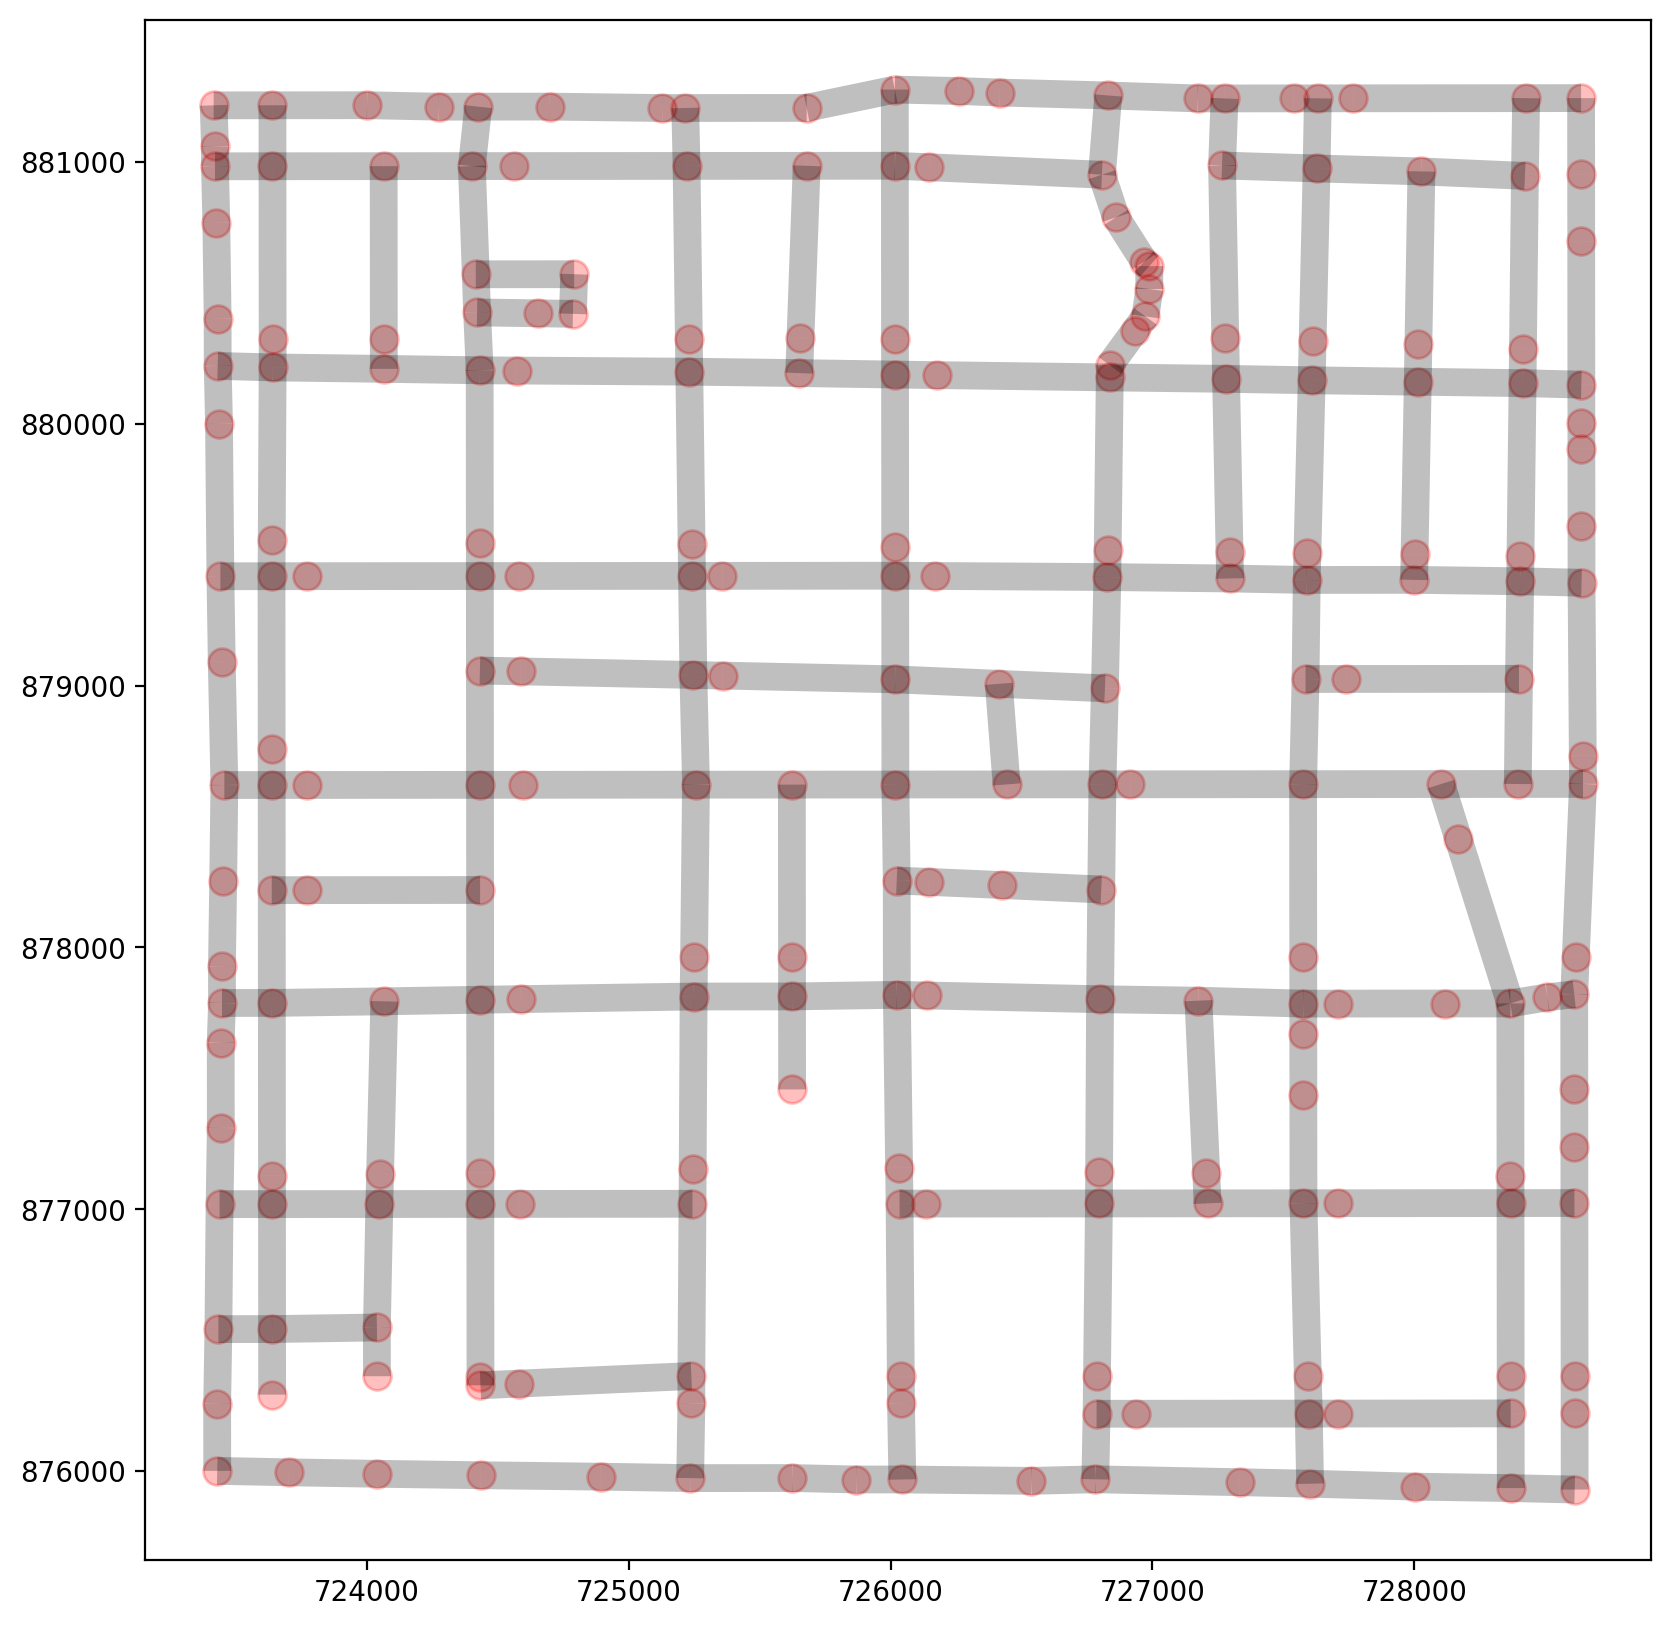

In [46]:
base = arcs.plot(linewidth=10, alpha=0.25, color="k", figsize=(10, 10))
vertices.plot(ax=base, markersize=100, alpha=0.25, color="red");

#### 2.2 Snap emprical observations and extract the point patterns as ``geopandas.GeoDataFrames``

In [47]:
ntw.snapobservations(libpysal.examples.get_path("schools.shp"), "schools")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="schools")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="schools", snapped=True)

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:100: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:1797: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


#### 2.3 Plot empirical data

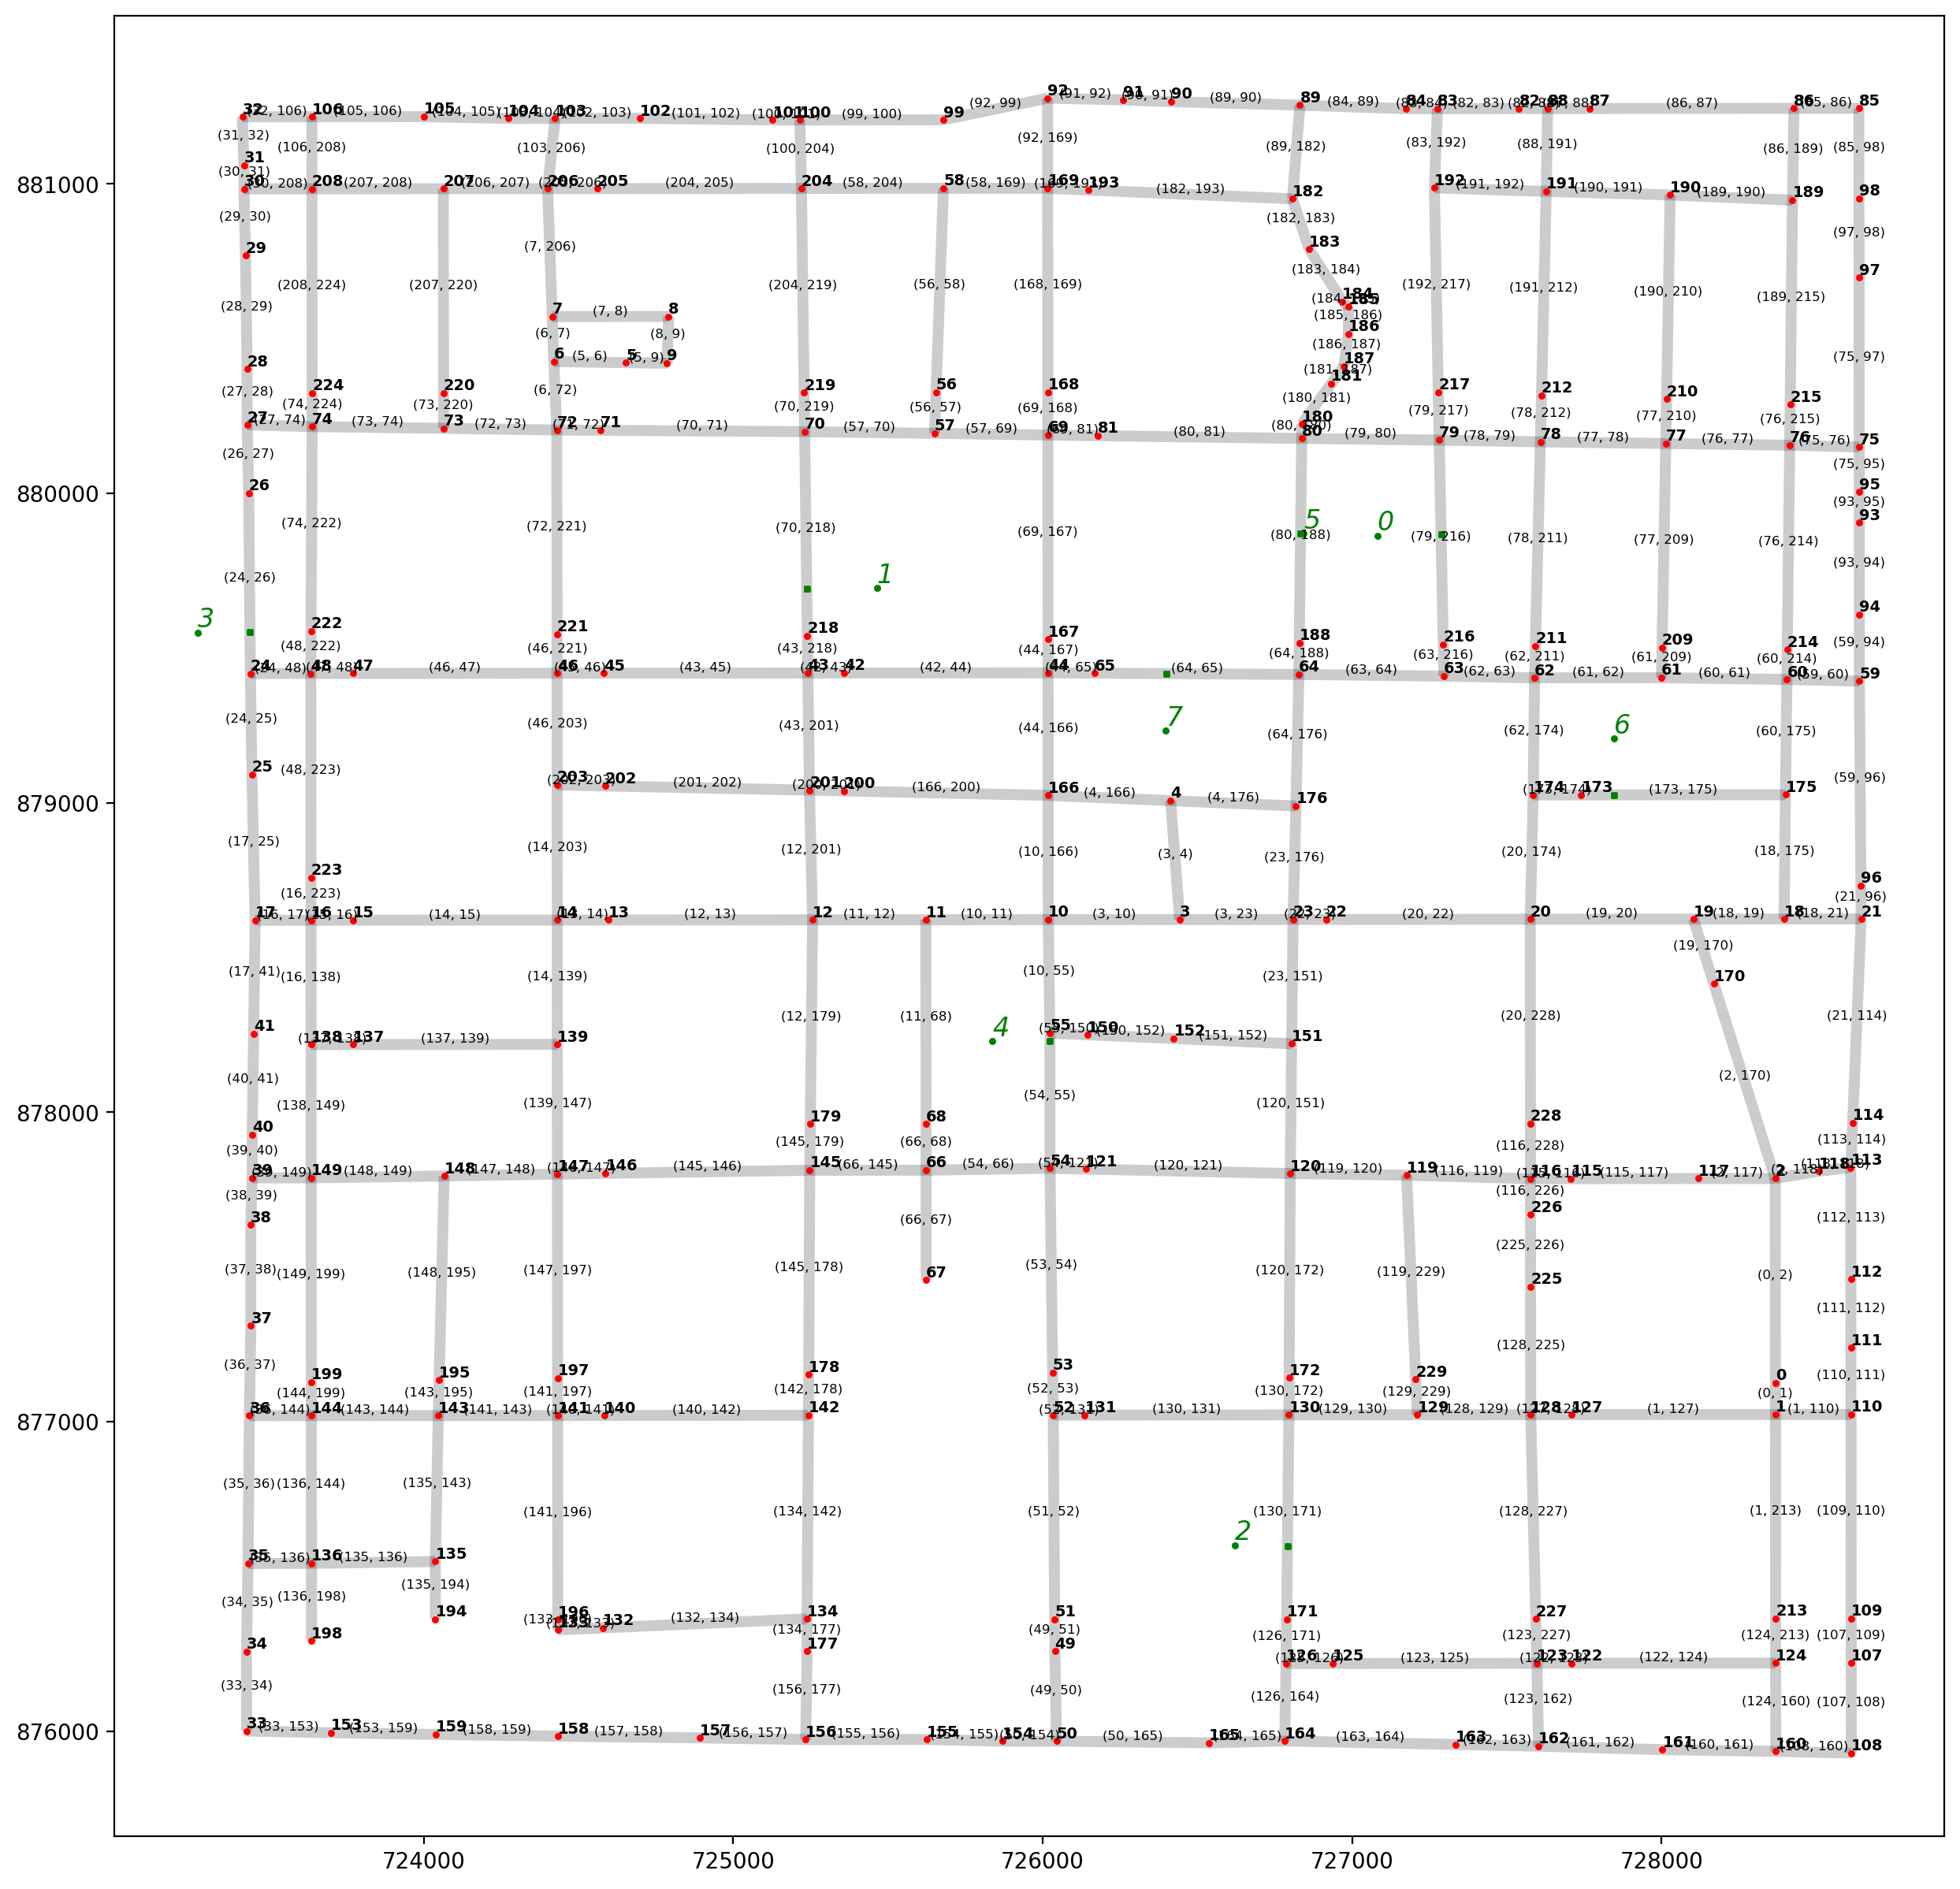

In [48]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(15, 15), zorder=0)
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=5, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=5, marker="s", color="g", zorder=2)
# arc labels
arc_labels(arcs, base, 6)
# vertex labels
vert_labels(vertices, base, 7)
# synthetic observation labels
obs_labels(pp_obs, base, 12);

#### 2.4 Generate shortest path routes and extract them

In [49]:
d2d_dist, tree = ntw.allneighbordistances("schools", gen_tree=True)
paths = ntw.shortest_paths(tree, "schools")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:100: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/g/anaconda3/envs/nkde/lib/python3.12/site-packages/libpysal/cg/shapes.py:932: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


,id,geometry
0,"(0, 1)","LINESTRING (727287.664 879867.386, 727294.797 ..."
1,"(0, 2)","LINESTRING (727287.664 879867.386, 727294.797 ..."
2,"(0, 3)","LINESTRING (727287.664 879867.386, 727294.797 ..."
3,"(0, 4)","LINESTRING (727287.664 879867.386, 727294.797 ..."
4,"(0, 5)","LINESTRING (727287.664 879867.386, 727281.557 ..."


#### 2.5 Plot the shortest path routes

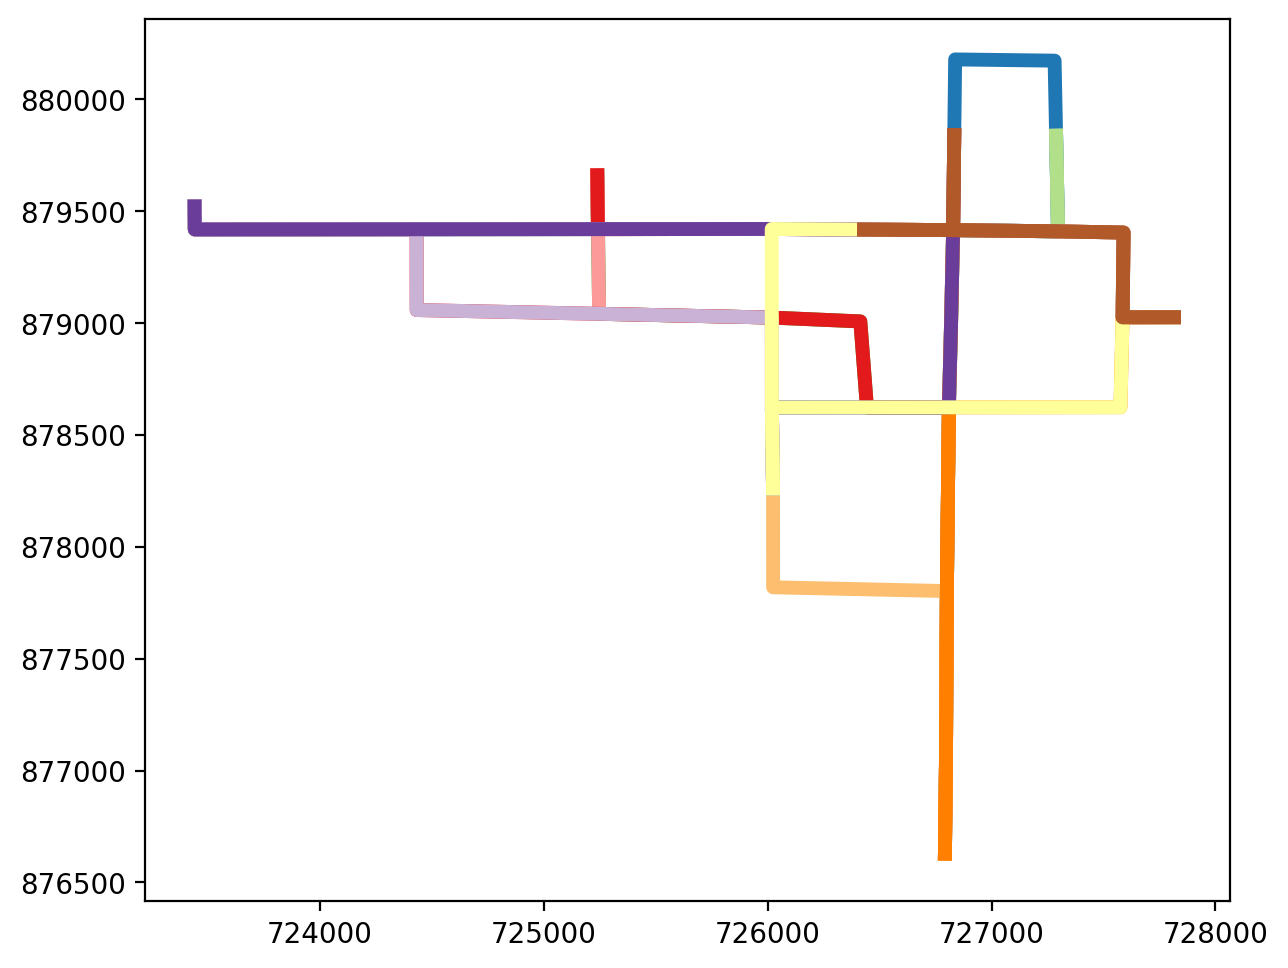

In [50]:
paths_gdf.plot(figsize=(7, 7), column="id", cmap="Paired", linewidth=5);

#### 2.6. Plot all shortest path routes within the context of the network

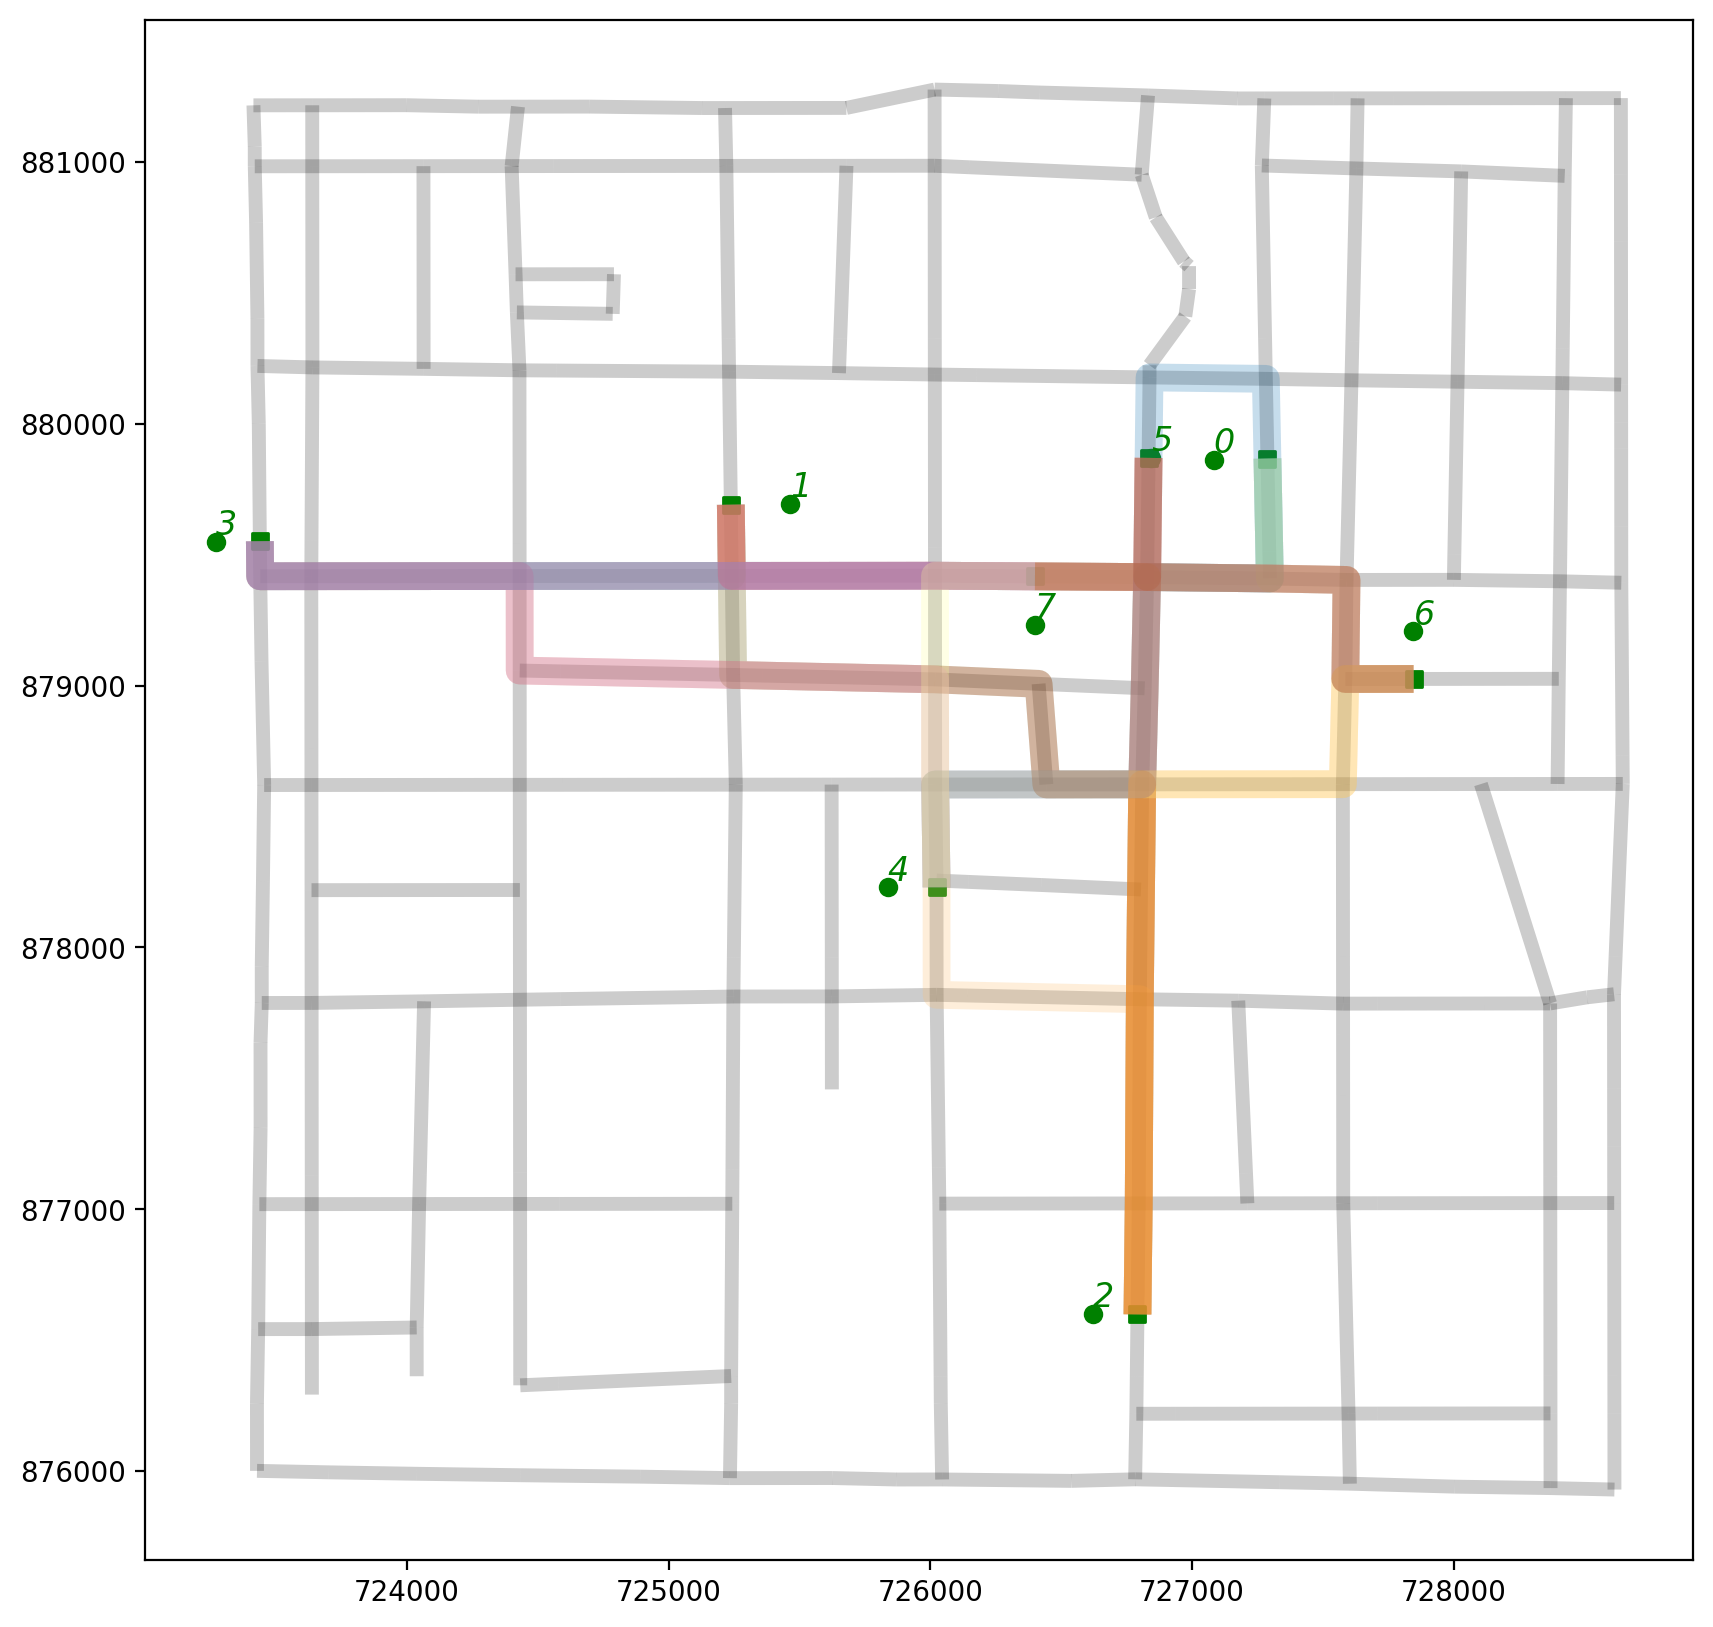

In [51]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obs.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="g", marker="s", zorder=2)
paths_gdf.plot(ax=base, column="id", cmap="Paired", linewidth=10, alpha=0.25)
# synthetic observation labels
obs_labels(pp_obs, base, 12);

#### 2.7. Plot the shortest path routes originating from observation ``0``

In [52]:
obs0 = 0
pp_ob0 = pp_obs[pp_obs["id"]==obs0]
pp_obX0 = pp_obs[pp_obs["id"]!=obs0]
orig_ob0 = paths_gdf[paths_gdf["id"].apply(lambda x: x[0]==obs0)]

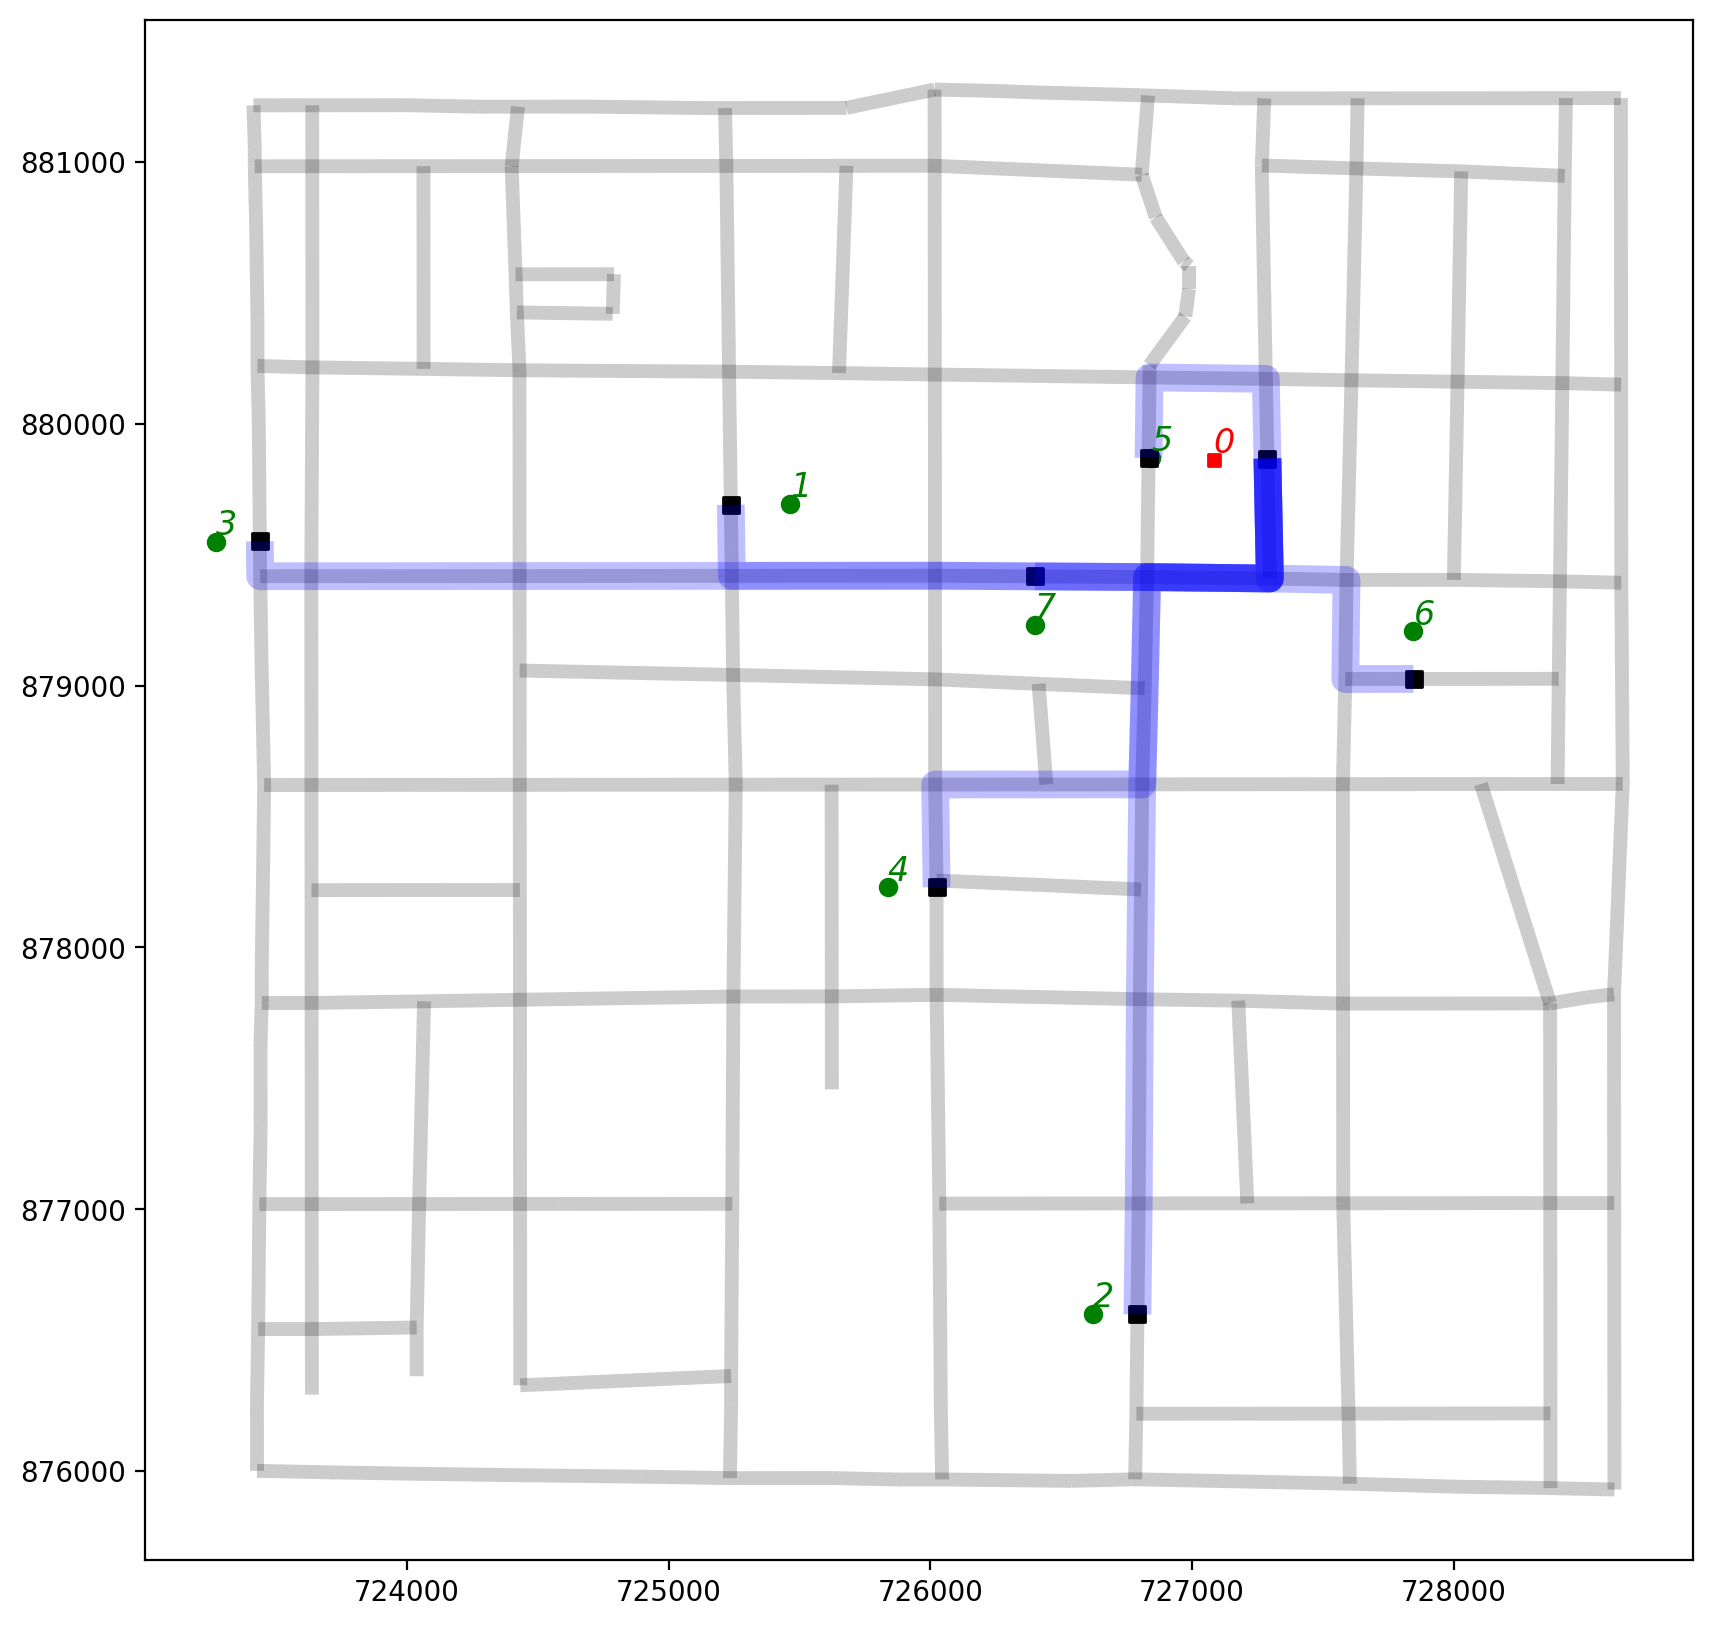

In [53]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obX0.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="k", marker="s", zorder=2)
pp_ob0.plot(ax=base, markersize=20, marker="s", color="r", zorder=2)
# routes originating from observation 0
orig_ob0.plot(ax=base, color="b", linewidth=10, alpha=0.25);
# synthetic observation labels
obs_labels(pp_obX0, base, 12, c="g");
# synthetic observation labels
obs_labels(pp_ob0, base, 12, c="r");

#### 2.8. Plot the shortest path routes arriving at observation ``4``
Since the point pattern is symmetric, origins equal destinations and the shortest paths IDs are sorted and pruned out. Therefore, we have to stipluate ***either*** ``O`` or ``D`` of ``4`` in this case.

In [54]:
obs4 = 4
pp_ob4 = pp_obs[pp_obs["id"]==obs4]
pp_obX4 = pp_obs[pp_obs["id"]!=obs4]
orig_ob4 = paths_gdf[paths_gdf["id"].apply(lambda x: x[0]==obs4 or x[1]==obs4)]

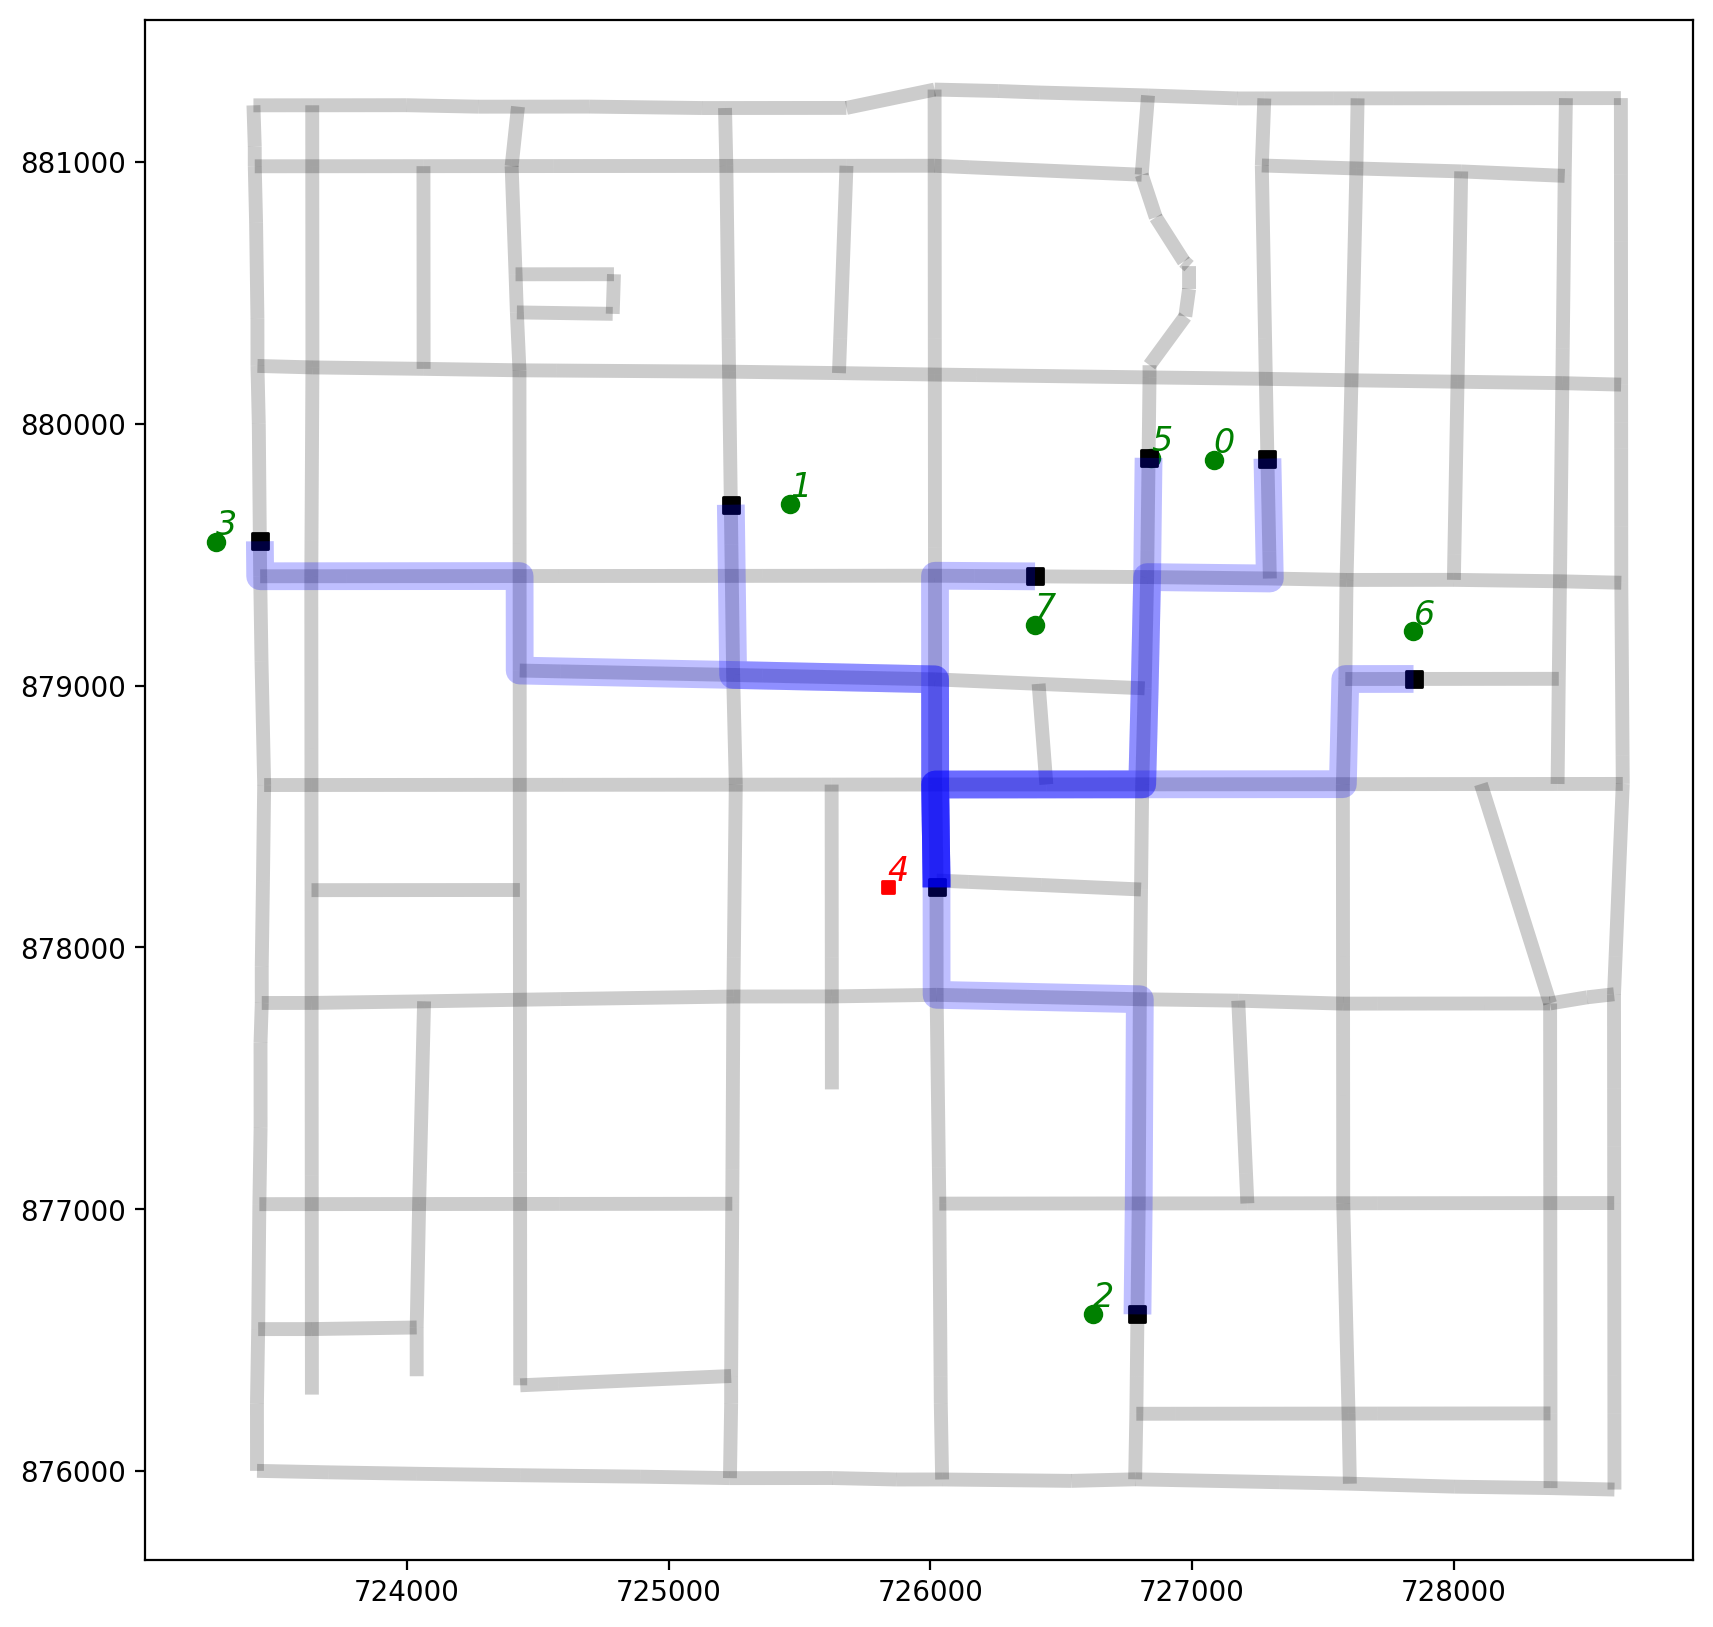

In [55]:
base = arcs.plot(alpha=0.2, linewidth=5, color="k", figsize=(10, 10), zorder=0)
pp_obX4.plot(ax=base, color="g", zorder=2)
pp_obs_snapped.plot(ax=base, color="k", marker="s", zorder=2)
pp_ob4.plot(ax=base, markersize=20, marker="s", color="r", zorder=2)
# routes originating from observation 4
orig_ob4.plot(ax=base, color="b", linewidth=10, alpha=0.25);
# synthetic observation labels
obs_labels(pp_obX4, base, 12, c="g");
# synthetic observation labels
obs_labels(pp_ob4, base, 12, c="r");

-----------------------